In [29]:
# normal imports
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
from datetime import datetime

In [30]:
#loading data
msft = yf.download("MSFT", "2023-01-01", "2023-12-31", interval="1h")
msft.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1742 entries, 2023-01-03 09:30:00-05:00 to 2023-12-29 15:30:00-05:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1742 non-null   float64
 1   High       1742 non-null   float64
 2   Low        1742 non-null   float64
 3   Close      1742 non-null   float64
 4   Adj Close  1742 non-null   float64
 5   Volume     1742 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 95.3 KB


<Axes: xlabel='Datetime'>

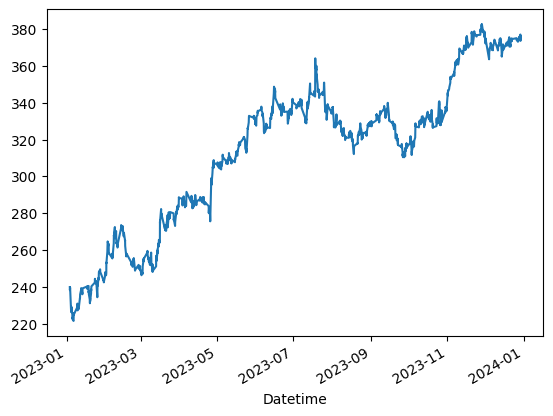

In [31]:
#plotting data
msft["Close"].plot()

In [32]:
# initializing df for organization
df = pd.DataFrame()
df["closes"] = msft["Close"].groupby(msft.index.floor("d")).apply(list)
df["open"] = [x[0] for x in msft["Open"].groupby(msft.index.floor("d")).apply(list)]
df.index = pd.to_datetime(df.index.date)

# dropping because of missing data
df = df.drop(["2023-07-03", "2023-11-24"], axis=0)

In [33]:
# finding hourly move
def move(closes, open):
    return [np.abs(close/open - 1) for close in closes]

df["moves"] = df.apply(lambda x: move(x["closes"], x["open"]), axis=1)

In [34]:
# moving average of move values
def moving_average(data, n=14):
    ma = []
    for i in range(len(data)):
        if i < n:
            ma.append(data[i])
        else:
            window = data[i-n:i]
            ma.append(sum(window) / n)
    return ma

move_arr = np.stack(df["moves"].values)
open_arr = np.array([[val] * 7 for val in df["open"]])

avg_move_arr = np.apply_along_axis(moving_average, axis=0, arr=move_arr)

# upper and lower bounds
df["upper_bound"] = (open_arr * (1 + avg_move_arr)).tolist()
df["lower_bound"] = (open_arr * (1 - avg_move_arr)).tolist()

# account for 14 day lag from moving average and bad dates
df_lagged = df[14:]
msft_lagged = msft[msft.index.tz_localize(None) >= df.index[14]]
baddates = (msft_lagged.index.date != pd.Timestamp("2023-07-03").date()) & (msft_lagged.index.date != pd.Timestamp("2023-11-24").date())
msft_lagged = msft_lagged[baddates]

In [35]:


# flattening into one df
flat = pd.DataFrame(
    {"open": msft_lagged.loc[:, "Open"],
     "high": msft_lagged.loc[:, "High"],
     "low": msft_lagged.loc[:, "Low"],
     "close": np.stack(df_lagged["closes"]).flatten(),
     "upper_bound": np.stack(df_lagged["upper_bound"]).flatten(),
     "lower_bound": np.stack(df_lagged["lower_bound"]).flatten()},
     index=msft_lagged.index
)

flat.index = pd.Index(flat.index)
flat.loc[:, "open":"close"]

,open,high,low,close
Datetime,,,,
2023-01-24 09:30:00-05:00,242.500000,243.949997,240.889999,243.125000
2023-01-24 10:30:00-05:00,243.110001,243.470001,241.800003,242.425003
2023-01-24 11:30:00-05:00,242.440002,242.639999,241.479996,242.119995
2023-01-24 12:30:00-05:00,242.115005,242.190002,241.210007,241.869995
2023-01-24 13:30:00-05:00,241.860001,242.860001,241.610703,242.470001
...,...,...,...,...
2023-12-29 11:30:00-05:00,373.589996,374.640015,373.480011,373.690002
2023-12-29 12:30:00-05:00,373.690002,375.910004,373.630005,375.255005
2023-12-29 13:30:00-05:00,375.230011,376.500000,375.200012,376.043213


In [36]:
# implementing in nautilus trader

In [3]:
# nautilus trader imports
from nautilus_trader.backtest.engine import BacktestEngine
from nautilus_trader.backtest.engine import BacktestEngineConfig
from nautilus_trader.trading.strategy import Strategy
from nautilus_trader.model.currencies import USD
from nautilus_trader.model.data import BarType
from nautilus_trader.model.enums import AccountType
from nautilus_trader.model.enums import OmsType
from nautilus_trader.model.identifiers import Venue
from nautilus_trader.model.objects import Money
from nautilus_trader.persistence.wranglers import BarDataWrangler
from nautilus_trader.test_kit.providers import TestInstrumentProvider
from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAP
from nautilus_trader.examples.strategies.ema_cross_twap import EMACrossTWAPConfig
from decimal import Decimal
from nautilus_trader.config import StrategyConfig
from nautilus_trader.model.identifiers import InstrumentId
from nautilus_trader.model.instruments import Instrument
from nautilus_trader.model.orders.list import OrderList
from nautilus_trader.trading.strategy import Strategy
from nautilus_trader.model.data.bar import Bar, BarSpecification
from nautilus_trader.model.enums import OrderSide, PositionSide, TimeInForce
from nautilus_trader.common.enums import LogColor

ModuleNotFoundError: No module named 'nautilus_trader.model.data.bar'; 'nautilus_trader.model.data' is not a package

In [38]:
# engine
engine = BacktestEngine()

#venue
SIM = Venue("SIM")
engine.add_venue(
    venue=SIM,
    oms_type=OmsType.NETTING,  # Venue will generate position IDs
    account_type=AccountType.CASH,
    base_currency=USD,  # Standard single-currency account
    starting_balances=[Money(100_000, USD)]  # Single-currency or multi-currency accounts
)

In [39]:
# instrument
MSFT_SIM = TestInstrumentProvider.equity(symbol="MSFT", venue="SIM")
engine.add_instrument(MSFT_SIM)

# process into nautilus objects
bartype = BarType.from_str("MSFT.SIM-1-HOUR-MID-EXTERNAL")
wrangler = BarDataWrangler(instrument=MSFT_SIM, bar_type=bartype)
bars = wrangler.process(flat.loc[:, "open":"close"])

In [40]:
# add data
engine.add_data(bars)

In [46]:
# Run the engine (from start to end of data)
engine.run()

In [48]:
engine.trader.generate_positions_report()

""
